In [2]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('src/')

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Toy

In [4]:
from dasbm.data import DiscreteGaussianDataset, DiscreteSwissRollDataset
from dasbm.data import Prior
from dasbm.models.toy import D3PM

## Data

In [10]:
num_samples = 1024

num_categories = 50
num_timesteps = 10
num_skip_steps = 1

In [11]:
dataset_x = DiscreteSwissRollDataset(num_samples, noise=0.8, num_categories=num_categories, train=False)[5:]
dataset_y = DiscreteGaussianDataset(num_samples, dim=2, num_categories=num_categories, train=False)[5:]

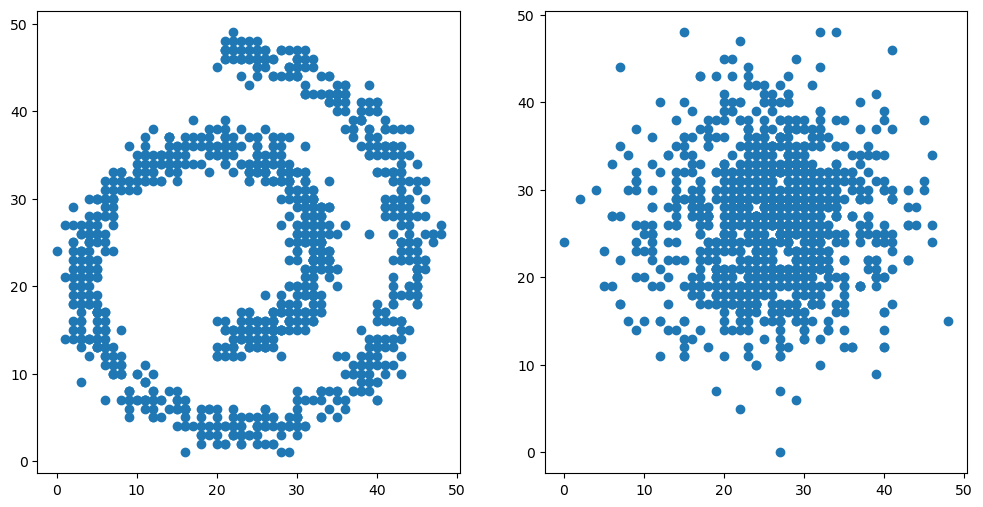

In [12]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(dataset_x[:, 0], dataset_x[:, 1])
axs[1].scatter(dataset_y[:, 0], dataset_y[:, 1])
plt.show()

## Prior

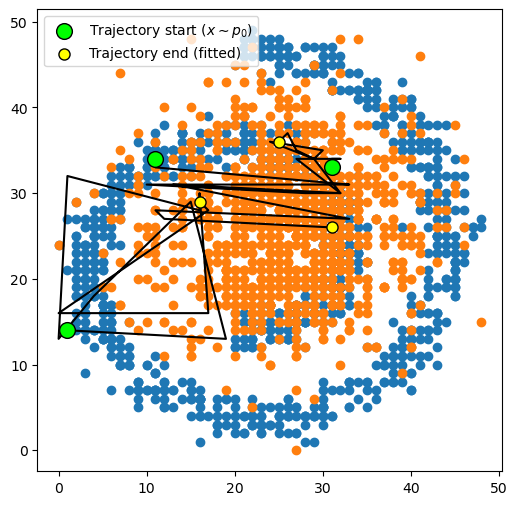

In [13]:
alpha = 0.05
prior_type = 'gaussian'

prior = Prior(
    alpha=alpha, 
    num_categories=num_categories, 
    num_timesteps=num_timesteps, 
    num_skip_steps=num_skip_steps,
    prior_type=prior_type
)
x_start = dataset_x[:3]
x_end = dataset_y[:3]
bridge_samples = []
bridge_samples.append(x_start)
for timestep in range(1, num_timesteps + 1):
    t = torch.full((3, 1), timestep)
    x_t = prior.sample_bridge(x_start, x_end, t)
    bridge_samples.append(x_t)
    # break
bridge_samples.append(x_end)
bridge_samples = torch.stack(bridge_samples, dim=0)

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x_start[:, 0], x_start[:, 1], c="lime", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)
ax.scatter(x_end[:, 0], x_end[:, 1], c="yellow", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)
for i in range(3):
    ax.plot(bridge_samples[::1, i, 0], bridge_samples[::1, i, 1], "black", markeredgecolor="black", linewidth=1.5, zorder=2)

ax.scatter(dataset_x[:, 0], dataset_x[:, 1])
ax.scatter(dataset_y[:, 0], dataset_y[:, 1])
plt.legend()
plt.show()

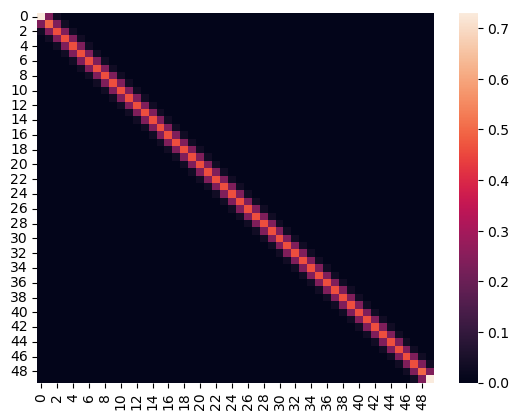

tensor(1., dtype=torch.float64) tensor(1., dtype=torch.float64)


In [14]:
i = 1
sns.heatmap(prior.p_cum[i])
plt.show()
print(prior.p_cum[i, 0].sum(), prior.p_onestep[i, 0].sum())

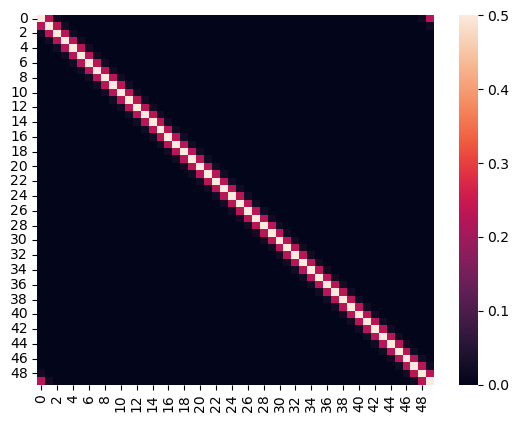

In [118]:
alpha = 0.01
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False)
p_onestep_mats = np.zeros((num_categories, num_categories))

for i, current_angle in enumerate(angles):
    for j, next_angle in enumerate(angles):
        p_onestep_mats[i, j] = np.exp(np.cos(next_angle - current_angle) / alpha)
    p_onestep_mats[i] /= np.sum(p_onestep_mats[i])
sns.heatmap(p_onestep_mats)
plt.show()

/trinity/home/g.ksenofontov/anaconda3/envs/disc_sbm/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


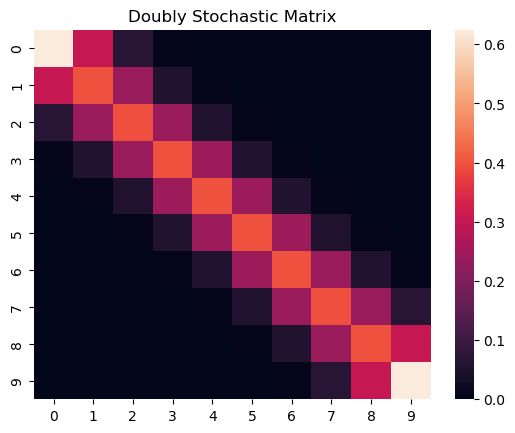

Row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
Column sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [74]:
import ot

alpha = 2
cost = torch.zeros((num_categories, num_categories))

for i in range(num_categories):
    indices = torch.arange(num_categories).float()
    cost[i] = ((indices - i) ** 2)

# sns.heatmap(cost)    
# plt.show()

a = torch.ones(num_categories) / num_categories
b = torch.ones(num_categories) / num_categories

sinkhorn_matrix = ot.sinkhorn(a, b, M=cost, reg=alpha, nummaxiter=5000) * 10

sns.heatmap(sinkhorn_matrix)
plt.title("Doubly Stochastic Matrix")
plt.show()

sns.heatmap(sinkhorn_matrix)

0.10000585238540272
0.21506150058130555
0.3498554761242309
0.4571692009516257
0.23834742052870583
0.4629523469712871
0.4638066938181813
0.35891049568545963
0.212801640160825
0.12218183460697152


<Axes: >

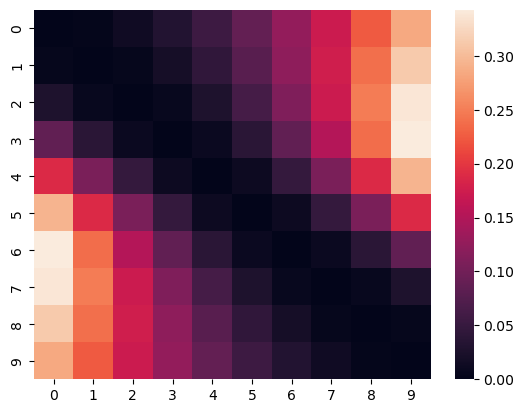

In [77]:
from scipy.optimize import minimize_scalar

def compute_sigma(i, num_categories, alpha):
    def objective(sigma):
        j = np.arange(num_categories)
        probs = np.exp(-((j - i) ** 2) / (2 * sigma ** 2))
        probs[i] = alpha
        tail_sum = probs.sum() - alpha
        normalized_tail = probs / probs.sum()
        mean = np.sum(j * normalized_tail)
        return (mean - i) ** 2

    res = minimize_scalar(objective, bounds=(0.1, num_categories), method='bounded')
    return res.x

alpha = 2
probs = torch.zeros((num_categories, num_categories))

for i in range(num_categories):
    indices = torch.arange(num_categories).float()
    sigma = compute_sigma(i, num_categories, alpha)
    print(sigma)
    probs[i] = ((indices - i) ** 2) / (sigma ** 2)
    probs[i] /= probs[i].sum()

sns.heatmap(probs)

## Model

In [8]:
forward_model = D3PM(
    input_dim=2,
    num_categories=num_categories, 
    num_timesteps=num_timesteps,
)
backward_model = D3PM(
    input_dim=2,
    num_categories=num_categories, 
    num_timesteps=numd_timesteps,
)

test_start = forward_model.sample(x_start, prior)
test_end = backward_model.sample(x_start, prior)

print(test_start, test_end)

NameError: name 'numd_timesteps' is not defined

# Graph data

In [3]:
train = moses.get_dataset('train')[:1000]
sampler = MoleculeDatasetSampler(train)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
samples = sampler.sample(100)
samples

Molecule(nodes=torch.Size([100, 26, 8]), edges=torch.Size([100, 26, 26, 5]), features=torch.Size([100, 0]), mask=torch.Size([100, 26]))

In [40]:
samples.features

tensor([], size=(100, 0))